In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from arch.bootstrap import MCS

In [ ]:

class BaseBandit:
    def __init__(self, narms):
        self.narms = narms
        self.counts = np.zeros(narms)
        self.values = np.zeros(narms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] += (reward - value) / n


In [ ]:
class EpsGreedy(BaseBandit):
    def __init__(self, narms, epsilon):
        super().__init__(narms)
        self.epsilon = epsilon

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.narms)
        else:
            return np.argmax(self.values)
        
class UCB(BaseBandit):
    def __init__(self, narms):
        super().__init__(narms)
        self.total_counts = 0

    def select_arm(self):
        self.total_counts += 1
        if 0 in self.counts:
            return np.argmin(self.counts)
        confidence_bounds = self.values + np.sqrt(2 * np.log(self.total_counts) / self.counts)
        return np.argmax(confidence_bounds)


In [17]:
def run_experiment(policy_class, true_means, steps, **kwargs):
    narms = len(true_means)
    bandit = policy_class(narms, **kwargs)
    rewards = np.zeros(steps)

    for t in range(steps):
        arm = bandit.select_arm()
        reward = np.random.normal(true_means[arm], 1.0)
        bandit.update(arm, reward)
        rewards[t] = reward

    return rewards

In [ ]:
'''Setup parameters'''
np.random.seed(42)
num_arms = 10
steps = 200
repeats = 2000
epsilons = [0.0, 0.1, 0.3, 0.5]
true_means = np.random.normal(0, 1, num_arms)

cumulative_rewards = {}

In [ ]:
""" Epsilon-Greedy """
for eps in epsilons:
    policy_name = f"Eps={eps}"
    reward_list = []

    for _ in range(repeats):
        rewards = run_experiment(EpsGreedy, true_means, steps, epsilon=eps)
        total_reward = rewards.sum()
        reward_list.append(total_reward)

    cumulative_rewards[policy_name] = reward_list

''' UCB '''
policy_name = "UCB"
reward_list = []

for _ in range(repeats):
    rewards = run_experiment(UCB, true_means, steps)
    total_reward = rewards.sum()
    reward_list.append(total_reward)

cumulative_rewards[policy_name] = reward_list

In [ ]:
'''构造 reward matrix 和 loss matrix'''
policy_names = list(cumulative_rewards.keys())
reward_matrix = []

for i in range(repeats):
    row = []
    for policy in policy_names:
        row.append(cumulative_rewards[policy][i])
    reward_matrix.append(row)
# policy number * repeats
reward_matrix = np.array(reward_matrix)
loss_matrix = -1 * reward_matrix  


# 应用 MCS
mcs = MCS(loss_matrix, size=0.05, reps=1000, block_size=1)
mcs.compute()

included_indices = mcs.included
included_policies = [policy_names[i] for i in included_indices]

print("MCS 95%:")
print(included_policies)

MCS 95%:
['UCB']


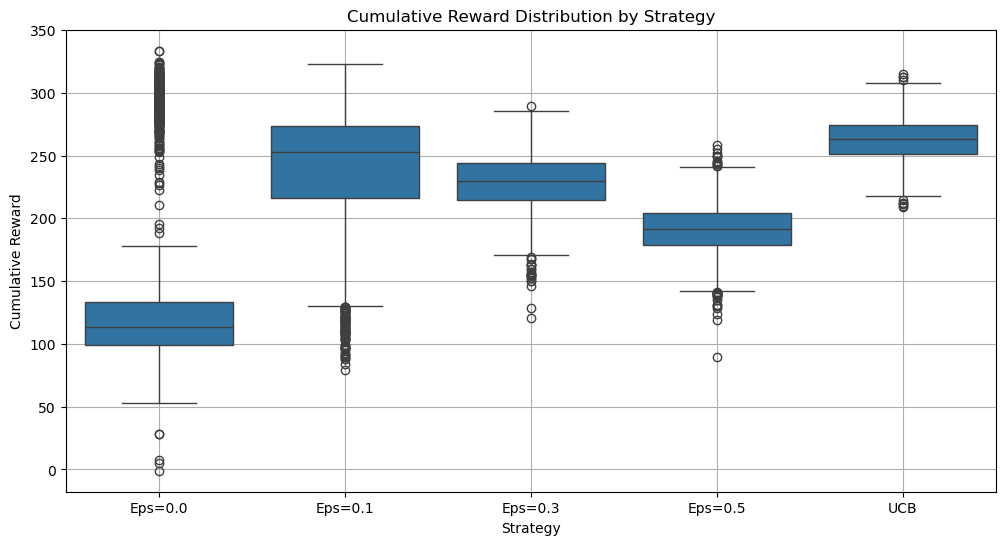

In [ ]:
# 将结果转换为 DataFrame 以便于可视化
df = pd.DataFrame(cumulative_rewards)
df_melted = df.melt(var_name="Strategy", value_name="Cumulative Reward")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Strategy", y="Cumulative Reward")
plt.title("Cumulative Reward Distribution by Strategy")
plt.grid(True)
plt.show()

In [20]:
df


,Eps=0.0,Eps=0.1,Eps=0.3,Eps=0.5,UCB
0,324.815669,227.358071,213.829854,171.515932,265.936073
1,273.178275,246.278201,227.979972,187.539797,259.052640
2,86.372635,104.566027,212.820189,178.750112,250.996021
3,122.195381,121.138225,200.718187,197.838367,287.073731
4,102.573848,275.741065,245.889459,189.013932,286.388390
...,...,...,...,...,...
1995,124.658800,195.676006,193.036919,206.365061,266.323852
1996,128.164473,264.846189,250.662252,204.570150,260.275721
1997,82.229565,263.871977,260.184703,191.560819,256.444730
1998,300.236059,272.071383,252.459672,167.289091,240.055406


In [22]:
reward_matrix

array([[324.81566878, 227.35807108, 213.82985377, 171.51593217,
        265.93607296],
       [273.17827542, 246.27820088, 227.97997151, 187.53979702,
        259.05264028],
       [ 86.37263505, 104.5660268 , 212.82018905, 178.75011204,
        250.99602123],
       ...,
       [ 82.22956482, 263.87197678, 260.18470259, 191.56081899,
        256.4447302 ],
       [300.23605942, 272.07138308, 252.45967189, 167.28909118,
        240.05540564],
       [ 88.89360129, 257.24382965, 218.83426761, 183.27761651,
        264.86379252]])

In [23]:
df_melted

,Strategy,Cumulative Reward
0,Eps=0.0,324.815669
1,Eps=0.0,273.178275
2,Eps=0.0,86.372635
3,Eps=0.0,122.195381
4,Eps=0.0,102.573848
...,...,...
9995,UCB,266.323852
9996,UCB,260.275721
9997,UCB,256.444730
9998,UCB,240.055406
